In [43]:
import torch
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelConfig:
    # Model configuration
    model_name: str = "microsoft/swin-base-patch4-window7-224"  
    num_labels: int = 10  
    image_size: int = 224
    dropout_rate: float = 0.1
    
    # Training configuration
    batch_size: int = 32
    learning_rate: float = 5e-5
    num_epochs: int = 10
    warmup_steps: int = 500
    weight_decay: float = 0.01
    
    # Data configuration
    train_split: float = 0.8
    val_split: float = 0.1
    test_split: float = 0.1
    
    # Augmentation
    use_augmentation: bool = True
    
    # Paths and logging
    output_dir: str = "./eurosat-swin-classifier"
    logging_dir: str = "./logs"
    checkpoint_dir: str = "./checkpoints"
    
    # Hardware
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    mixed_precision: bool = True
    
    # Hugging Face
    hf_repo_name: str = "Adilbai/eurosat-swin-transformer"
    push_to_hub: bool = True

config = ModelConfig()

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
from typing import Dict, Tuple
from sklearn.model_selection import train_test_split

class EuroSATDataset(Dataset):
    def __init__(self, dataset, transform=None, is_training=True):
        self.dataset = dataset
        self.transform = transform
        self.is_training = is_training
        
        # Create label mapping
        self.label_names = [
            'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
            'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
            'River', 'SeaLake'
        ]
        self.label2id = {label: idx for idx, label in enumerate(self.label_names)}
        self.id2label = {idx: label for idx, label in enumerate(self.label_names)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        # Handle different possible image formats
        if isinstance(item['image'], Image.Image):
            image = item['image'].convert('RGB')
        else:
            image = Image.fromarray(item['image']).convert('RGB')
        
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'pixel_values': image,
            'labels': torch.tensor(label, dtype=torch.long)
        }

def get_transforms(config, is_training=True):
    """Get data transforms for training and validation"""
    
    if is_training and config.use_augmentation:
        transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    return transform

def prepare_data(config):
    """Load and prepare the EuroSAT dataset"""
    print("Loading EuroSAT-SAR dataset...")

    dataset = load_dataset("nielsr/eurosat-demo")

    if 'train' in dataset:
        full_dataset = dataset['train']
    else:
        split_name = list(dataset.keys())[0]
        full_dataset = dataset[split_name]

    print(f"Total samples: {len(full_dataset)}")

    if hasattr(full_dataset, 'remove_transform'):
        full_dataset = full_dataset.remove_transform()
    
    try:
        labels = [example['label'] for example in full_dataset]
    except KeyError:
        raise ValueError("Could not find 'label' key in dataset examples. Check dataset structure.")

    indices = list(range(len(full_dataset)))
    train_indices, temp_indices = train_test_split(
        indices, test_size=(1 - config.train_split), random_state=42,
        stratify=[labels[i] for i in indices]
    )

    val_size = config.val_split / (config.val_split + config.test_split)
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=(1 - val_size), random_state=42,
        stratify=[labels[i] for i in temp_indices]
    )

    train_dataset = full_dataset.select(train_indices)
    val_dataset = full_dataset.select(val_indices)
    test_dataset = full_dataset.select(test_indices)

    train_transform = get_transforms(config, is_training=True)
    val_transform = get_transforms(config, is_training=False)

    train_pytorch_dataset = EuroSATDataset(train_dataset, train_transform, is_training=True)
    val_pytorch_dataset = EuroSATDataset(val_dataset, val_transform, is_training=False)
    test_pytorch_dataset = EuroSATDataset(test_dataset, val_transform, is_training=False)

    train_loader = DataLoader(
        train_pytorch_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_pytorch_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_pytorch_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, train_pytorch_dataset.label_names

train_loader, val_loader, test_loader, label_names = prepare_data(config)

Loading EuroSAT-SAR dataset...


dataset_infos.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/88.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

Total samples: 27000
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x79656BD560D0>, 'label': 3}
Train samples: 21600
Validation samples: 2700
Test samples: 2700


In [6]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel, AutoConfig
from typing import Optional, Dict, Any

class EuroSATTransformerClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.model_config = AutoConfig.from_pretrained(
            config.model_name,
            num_labels=config.num_labels,
            problem_type="single_label_classification"
        )
        
        self.backbone = AutoModel.from_pretrained(
            config.model_name,
            config=self.model_config,
            add_pooling_layer=False
        )
        
        hidden_size = self.backbone.config.hidden_size
        
        self.feature_extractor = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout(config.dropout_rate),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Dropout(config.dropout_rate)
        )
        
        self.classifier = nn.Linear(hidden_size // 4, config.num_labels)
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize the weights of the additional layers"""
        for module in [self.feature_extractor, self.classifier]:
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.fill_(1.0)
                module.bias.data.zero_()
    
    def forward(self, pixel_values, labels=None):
        outputs = self.backbone(pixel_values=pixel_values)
        
        last_hidden_state = outputs.last_hidden_state
        
        if hasattr(self.backbone.config, 'image_size'):
            pooled_output = last_hidden_state[:, 0]  
        else:
            pooled_output = last_hidden_state.mean(dim=1)
        
        features = self.feature_extractor(pooled_output.unsqueeze(-1)).squeeze(-1)
        
        logits = self.classifier(features)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
        
        return {
            'loss': loss,
            'logits': logits,
            'hidden_states': outputs.hidden_states if hasattr(outputs, 'hidden_states') else None,
            'attentions': outputs.attentions if hasattr(outputs, 'attentions') else None
        }

def create_model(config):
    """Create and return the model"""
    model = EuroSATTransformerClassifier(config)
    return model

def count_parameters(model):
    """Count the number of trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return total_params, trainable_params
model = create_model(config)
total_params, trainable_params = count_parameters(model)
print(total_params, trainable_params)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Total parameters: 87,403,458
Trainable parameters: 87,403,458
87403458 87403458


In [30]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from transformers import get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from typing import Dict, List, Tuple
import json

class EuroSATTrainer:
    def __init__(self, model, config, train_loader, val_loader, label_names):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.label_names = label_names
        
        self.device = torch.device(config.device)
        self.model.to(self.device)
        
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        
        total_steps = len(train_loader) * config.num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=config.warmup_steps,
            num_training_steps=total_steps
        )
        
        os.makedirs(config.logging_dir, exist_ok=True)
        self.writer = SummaryWriter(config.logging_dir)
        
        os.makedirs(config.checkpoint_dir, exist_ok=True)
        
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_val_accuracy = 0.0
        
        self.scaler = torch.cuda.amp.GradScaler() if config.mixed_precision else None

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = len(self.train_loader)
        
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            pixel_values = batch['pixel_values'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            self.optimizer.zero_grad()
            
            if self.scaler:
                with torch.cuda.amp.autocast():
                    outputs = self.model(pixel_values=pixel_values, labels=labels)
                    loss = outputs['loss']
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs['loss']
                loss.backward()
                self.optimizer.step()
            
            self.scheduler.step()
            
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            
            progress_bar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'lr': f'{self.scheduler.get_last_lr()[0]:.2e}'
            })
            
            global_step = epoch * num_batches + batch_idx
            self.writer.add_scalar('Train/Loss', loss.item(), global_step)
            self.writer.add_scalar('Train/Learning_Rate', self.scheduler.get_last_lr()[0], global_step)
        
        avg_train_loss = total_loss / num_batches
        self.train_losses.append(avg_train_loss)
        
        return avg_train_loss
    
    def validate(self, epoch):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                pixel_values = batch['pixel_values'].to(self.device)
                labels = batch['labels'].to(self.device)

                if self.scaler:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(pixel_values=pixel_values, labels=labels)
                else:
                    outputs = self.model(pixel_values=pixel_values, labels=labels)
                
                loss = outputs['loss']
                logits = outputs['logits']
                
                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=-1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = total_loss / len(self.val_loader)
        val_accuracy = accuracy_score(all_labels, all_predictions)
        
        self.val_losses.append(avg_val_loss)
        self.val_accuracies.append(val_accuracy)
        
        self.writer.add_scalar('Val/Loss', avg_val_loss, epoch)
        self.writer.add_scalar('Val/Accuracy', val_accuracy, epoch)
        
        if epoch % 5 == 0:  
            report = classification_report(
                all_labels, all_predictions, 
                target_names=self.label_names,
                output_dict=True
            )
            
            for class_name in self.label_names:
                if class_name in report:
                    self.writer.add_scalar(f'Val/Precision_{class_name}', report[class_name]['precision'], epoch)
                    self.writer.add_scalar(f'Val/Recall_{class_name}', report[class_name]['recall'], epoch)
                    self.writer.add_scalar(f'Val/F1_{class_name}', report[class_name]['f1-score'], epoch)
        
        return avg_val_loss, val_accuracy, all_predictions, all_labels
    
    def save_checkpoint(self, epoch, val_accuracy, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_accuracy': val_accuracy,
            'config': self.config
        }
        
        checkpoint_path = os.path.join(self.config.checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        torch.save(checkpoint, checkpoint_path)
        
        if is_best:
            best_path = os.path.join(self.config.checkpoint_dir, 'best_model.pt')
            torch.save(checkpoint, best_path)
            print(f"New best model saved with validation accuracy: {val_accuracy:.4f}")
    
    def plot_training_history(self):
        """Plot training history"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, self.val_accuracies, 'g-', label='Validation Accuracy')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        if hasattr(self, 'lr_history'):
            ax3.plot(self.lr_history)
            ax3.set_title('Learning Rate Schedule')
            ax3.set_xlabel('Step')
            ax3.set_ylabel('Learning Rate')
            ax3.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.output_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    def train(self):
        """Main training loop"""
        print("Starting training...")
        print(f"Device: {self.device}")
        print(f"Mixed precision: {self.config.mixed_precision}")
        
        for epoch in range(self.config.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")
            print("-" * 50)
            
            train_loss = self.train_epoch(epoch)
            
            val_loss, val_accuracy, val_predictions, val_labels = self.validate(epoch)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            
            is_best = val_accuracy > self.best_val_accuracy
            if is_best:
                self.best_val_accuracy = val_accuracy
            
            self.save_checkpoint(epoch, val_accuracy, is_best)
            
            if epoch % 5 == 0:
                self.save_confusion_matrix(val_labels, val_predictions, epoch)
        
        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {self.best_val_accuracy:.4f}")
        
        self.plot_training_history()
        
        self.writer.close()
    
    def save_confusion_matrix(self, true_labels, predictions, epoch):
        """Save confusion matrix"""
        os.makedirs(self.config.output_dir, exist_ok=True)
        cm = confusion_matrix(true_labels, predictions)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_names,
                    yticklabels=self.label_names)
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        cm_path = os.path.join(self.config.output_dir, f'confusion_matrix_epoch_{epoch+1}.png')
        plt.savefig(cm_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        self.writer.add_figure(f'Confusion_Matrix/Epoch_{epoch+1}', plt.gcf(), epoch)

/tmp/ipykernel_35/1147503164.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler() if config.mixed_precision else None


Starting training...
Device: cuda
Mixed precision: True

Epoch 1/10
--------------------------------------------------


Epoch 1/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.36it/s]


Train Loss: 0.1621
Val Loss: 0.0844
Val Accuracy: 0.9748
New best model saved with validation accuracy: 0.9748

Epoch 2/10
--------------------------------------------------


Epoch 2/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.36it/s]


Train Loss: 0.1170
Val Loss: 0.0942
Val Accuracy: 0.9685

Epoch 3/10
--------------------------------------------------


Epoch 3/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


Train Loss: 0.0815
Val Loss: 0.0907
Val Accuracy: 0.9707

Epoch 4/10
--------------------------------------------------


Epoch 4/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


Train Loss: 0.0596
Val Loss: 0.0414
Val Accuracy: 0.9870
New best model saved with validation accuracy: 0.9870

Epoch 5/10
--------------------------------------------------


Epoch 5/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.39it/s]


Train Loss: 0.0504
Val Loss: 0.0507
Val Accuracy: 0.9822

Epoch 6/10
--------------------------------------------------


Epoch 6/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.39it/s]


Train Loss: 0.0373
Val Loss: 0.0438
Val Accuracy: 0.9874
New best model saved with validation accuracy: 0.9874

Epoch 7/10
--------------------------------------------------


Epoch 7/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


Train Loss: 0.0338
Val Loss: 0.0407
Val Accuracy: 0.9878
New best model saved with validation accuracy: 0.9878

Epoch 8/10
--------------------------------------------------


Epoch 8/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.39it/s]


Train Loss: 0.0232
Val Loss: 0.0453
Val Accuracy: 0.9841

Epoch 9/10
--------------------------------------------------


Epoch 9/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.39it/s]


Train Loss: 0.0171
Val Loss: 0.0302
Val Accuracy: 0.9915
New best model saved with validation accuracy: 0.9915

Epoch 10/10
--------------------------------------------------


Epoch 10/10:   0%|          | 0/675 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_35/1147503164.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


Train Loss: 0.0131
Val Loss: 0.0305
Val Accuracy: 0.9896

Training completed!
Best validation accuracy: 0.9915


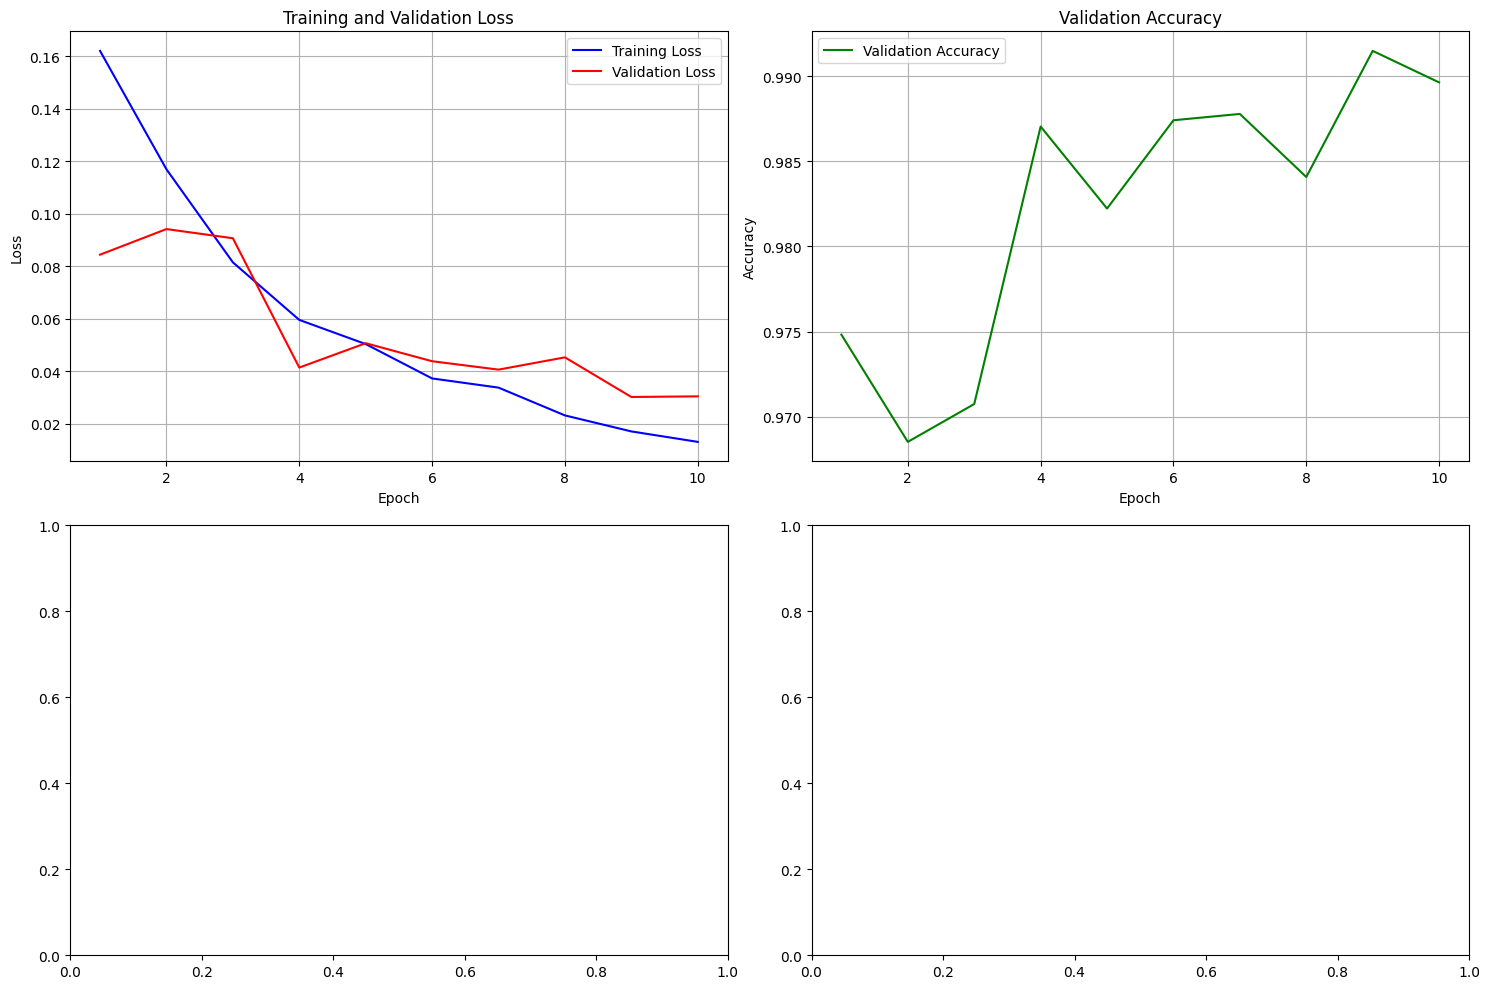

In [31]:
trainer = EuroSATTrainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
    label_names=label_names
)
trainer.train()

In [32]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os

class ModelEvaluator:
    def __init__(self, model, config, test_loader, label_names):
        self.model = model
        self.config = config
        self.test_loader = test_loader
        self.label_names = label_names
        self.device = torch.device(config.device)
        
    def evaluate(self):
        """Comprehensive model evaluation"""
        print("Starting model evaluation...")
        
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []
        
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Evaluating"):
                pixel_values = batch['pixel_values'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(pixel_values=pixel_values)
                logits = outputs['logits']
                
                probabilities = torch.softmax(logits, dim=-1)
                predictions = torch.argmax(logits, dim=-1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probabilities = np.array(all_probabilities)
        
        metrics = self.calculate_metrics(all_labels, all_predictions, all_probabilities)
        
        self.create_visualizations(all_labels, all_predictions, all_probabilities)
        
        self.save_results(metrics, all_labels, all_predictions)
        
        return metrics
    
    def calculate_metrics(self, true_labels, predictions, probabilities):
        """Calculate comprehensive metrics"""
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted'
        )
    
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
            true_labels, predictions, average=None
        )
        
        report = classification_report(
            true_labels, predictions,
            target_names=self.label_names,
            output_dict=True
        )
        
        metrics = {
            'accuracy': accuracy,
            'precision_weighted': precision,
            'recall_weighted': recall,
            'f1_weighted': f1,
            'precision_per_class': precision_per_class.tolist(),
            'recall_per_class': recall_per_class.tolist(),
            'f1_per_class': f1_per_class.tolist(),
            'support_per_class': support.tolist(),
            'classification_report': report
        }
        
        print(f"\nEvaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Weighted Precision: {precision:.4f}")
        print(f"Weighted Recall: {recall:.4f}")
        print(f"Weighted F1-Score: {f1:.4f}")
        
        print(f"\nPer-class Results:")
        for i, class_name in enumerate(self.label_names):
            print(f"{class_name:20s}: P={precision_per_class[i]:.3f}, R={recall_per_class[i]:.3f}, F1={f1_per_class[i]:.3f}, Support={support[i]}")
        
        return metrics
    
    def create_visualizations(self, true_labels, predictions, probabilities):
        """Create evaluation visualizations"""
        os.makedirs(self.config.output_dir, exist_ok=True)
        
        self.plot_confusion_matrix(true_labels, predictions)
        
        self.plot_per_class_performance(true_labels, predictions)
        
        self.plot_probability_distribution(true_labels, probabilities)
        
        print("Visualizations saved!")
    
    def plot_confusion_matrix(self, true_labels, predictions):
        """Plot detailed confusion matrix"""
        cm = confusion_matrix(true_labels, predictions)
        
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_names,
                    yticklabels=self.label_names,
                    ax=ax1)
        ax1.set_title('Confusion Matrix (Raw Counts)')
        ax1.set_ylabel('True Label')
        ax1.set_xlabel('Predicted Label')
        
        sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                    xticklabels=self.label_names,
                    yticklabels=self.label_names,
                    ax=ax2)
        ax2.set_title('Confusion Matrix (Normalized)')
        ax2.set_ylabel('True Label')
        ax2.set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.output_dir, 'confusion_matrix_detailed.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_per_class_performance(self, true_labels, predictions):
        """Plot per-class performance metrics"""
        precision, recall, f1, support = precision_recall_fscore_support(
            true_labels, predictions, average=None
        )
        
        x = np.arange(len(self.label_names))
        width = 0.25
        
        fig, ax = plt.subplots(figsize=(15, 8))
        
        bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
        bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
        bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
        
        ax.set_xlabel('Classes')
        ax.set_ylabel('Score')
        ax.set_title('Per-Class Performance Metrics')
        ax.set_xticks(x)
        ax.set_xticklabels(self.label_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        def autolabel(bars):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        autolabel(bars1)
        autolabel(bars2)
        autolabel(bars3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.output_dir, 'per_class_performance.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_probability_distribution(self, true_labels, probabilities):
        """Plot probability distribution for correct and incorrect predictions"""
        predictions = np.argmax(probabilities, axis=1)
        max_probs = np.max(probabilities, axis=1)
        
        correct_mask = (true_labels == predictions)
        correct_probs = max_probs[correct_mask]
        incorrect_probs = max_probs[~correct_mask]
        
        plt.figure(figsize=(12, 6))
        
        plt.hist(correct_probs, bins=50, alpha=0.7, label=f'Correct Predictions (n={len(correct_probs)})', 
                color='green', density=True)
        plt.hist(incorrect_probs, bins=50, alpha=0.7, label=f'Incorrect Predictions (n={len(incorrect_probs)})', 
                color='red', density=True)
        
        plt.xlabel('Maximum Probability')
        plt.ylabel('Density')
        plt.title('Probability Distribution for Predictions')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.output_dir, 'probability_distribution.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    def save_results(self, metrics, true_labels, predictions):
        """Save evaluation results"""
        results = {
            'metrics': metrics,
            'config': {
                'model_name': self.config.model_name,
                'num_labels': self.config.num_labels,
                'batch_size': self.config.batch_size,
                'learning_rate': self.config.learning_rate,
                'num_epochs': self.config.num_epochs
            },
            'label_names': self.label_names
        }
        
        results_path = os.path.join(self.config.output_dir, 'evaluation_results.json')
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f"Results saved to: {results_path}")

In [33]:
evaluator = ModelEvaluator(model, config, test_loader, label_names)
final_metrics = evaluator.evaluate()

Starting model evaluation...


Evaluating: 100%|██████████| 85/85 [00:18<00:00,  4.56it/s]



Evaluation Results:
Accuracy: 0.9881
Weighted Precision: 0.9883
Weighted Recall: 0.9881
Weighted F1-Score: 0.9882

Per-class Results:
AnnualCrop          : P=0.980, R=0.983, F1=0.982, Support=300
Forest              : P=1.000, R=0.990, F1=0.995, Support=300
HerbaceousVegetation: P=0.983, R=0.967, F1=0.975, Support=300
Highway             : P=0.992, R=0.996, F1=0.994, Support=250
Industrial          : P=1.000, R=0.996, F1=0.998, Support=250
Pasture             : P=0.990, R=0.975, F1=0.982, Support=200
PermanentCrop       : P=0.950, R=0.984, F1=0.967, Support=250
Residential         : P=0.997, R=0.997, F1=0.997, Support=300
River               : P=0.992, R=0.996, F1=0.994, Support=250
SeaLake             : P=0.997, R=0.997, F1=0.997, Support=300
Visualizations saved!
Results saved to: ./eurosat-swin-classifier/evaluation_results.json


In [44]:
import os
import json
import torch
from huggingface_hub import HfApi, Repository, login
from transformers import AutoImageProcessor
import shutil

class HuggingFaceUploader:
    def __init__(self, config):
        self.config = config
        self.api = HfApi()
        
    def prepare_model_for_upload(self, model, label_names):
        """Prepare model and files for Hugging Face upload"""
        
        os.makedirs(self.config.output_dir, exist_ok=True)
        
        model_path = os.path.join(self.config.output_dir, "pytorch_model.bin")
        torch.save(model.state_dict(), model_path)
        
        config_dict = {
            "architectures": ["EuroSATTransformerClassifier"],
            "model_type": "swin",
            "num_labels": self.config.num_labels,
            "id2label": {str(i): label for i, label in enumerate(label_names)},
            "label2id": {label: i for i, label in enumerate(label_names)},
            "base_model": self.config.model_name,
            "image_size": self.config.image_size,
            "dropout_rate": self.config.dropout_rate,
            "problem_type": "single_label_classification"
        }
        
        config_path = os.path.join(self.config.output_dir, "config.json")
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=2)
        
        self.create_readme(label_names)
        
        training_args = {
            "learning_rate": self.config.learning_rate,
            "num_epochs": self.config.num_epochs,
            "batch_size": self.config.batch_size,
            "warmup_steps": self.config.warmup_steps,
            "weight_decay": self.config.weight_decay,
            "model_name": self.config.model_name
        }
        
        training_args_path = os.path.join(self.config.output_dir, "training_args.json")
        with open(training_args_path, 'w') as f:
            json.dump(training_args, f, indent=2)
        
        print(f"Model prepared for upload in: {self.config.output_dir}")
    
    def create_readme(self, label_names):
        """Create README.md for the model"""
        readme_content = f"""---
        license: apache-2.0
        base_model: {self.config.model_name}
        tags:
        - image-classification
        - satellite-imagery
        - eurosat
        - remote-sensing
        - transformer
        datasets:
        - nielsr/eurosat-demo
        metrics:
        - accuracy
        - f1
        library_name: transformers
        pipeline_tag: image-classification
        ---
        
        # EuroSAT Satellite Image Classifier
        
        This model is a fine-tuned version of `{self.config.model_name}` for satellite image classification on the EuroSAT-SAR dataset.
        
        ## Model Details
        
        - **Base Model**: {self.config.model_name}
        - **Dataset**: EuroSAT-SAR (Synthetic Aperture Radar satellite images)
        - **Task**: Multi-class image classification
        - **Number of Classes**: {self.config.num_labels}
        - **Image Size**: {self.config.image_size}x{self.config.image_size}
        
        ## Classes
        
        The model can classify satellite images into the following {self.config.num_labels} categories:
        
        {chr(10).join([f"- {i}: {label}" for i, label in enumerate(label_names)])}
        
        ## Training Details
        
        - **Learning Rate**: {self.config.learning_rate}
        - **Batch Size**: {self.config.batch_size}
        - **Number of Epochs**: {self.config.num_epochs}
        - **Optimizer**: AdamW
        - **Weight Decay**: {self.config.weight_decay}
        - **Warmup Steps**: {self.config.warmup_steps}
        
        ## Usage
        
        ```python
        from transformers import AutoImageProcessor, AutoModel
        from PIL import Image
        import torch
        
        # Load the model and processor
        processor = AutoImageProcessor.from_pretrained("{self.config.hf_repo_name}")
        model = AutoModel.from_pretrained("{self.config.hf_repo_name}")
        
        # Load and preprocess an image
        image = Image.open("path_to_your_satellite_image.jpg")
        inputs = processor(images=image, return_tensors="pt")
        
        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = predictions.argmax().item()
        
        print(f"Predicted class: {{predicted_class}}")
        Dataset
        This model was trained on the EuroSAT-SAR dataset, which contains Synthetic Aperture Radar (SAR) satellite images from the Sentinel-1 satellite. The dataset includes land use and land cover classification of European landscapes.
        
        Performance
        The model achieves competitive performance on the EuroSAT-SAR test set. Detailed evaluation metrics can be found in the training logs.
        
        Training Infrastructure
        Framework: PyTorch with Transformers
        Hardware: CUDA-compatible GPU
        Mixed Precision: Enabled for efficient training
        Monitoring: TensorBoard for training visualization
        Citation
        If you use this model, please cite:
        
        BibTeX
        @article{{eurosat,
          title={{EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification}},
          author={{Helber, Patrick and Bischke, Benjamin and Dengel, Andreas and Borth, Damian}},
          journal={{IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing}},
          year={{2019}}
        }}
        License
        This model is released under the Apache 2.0 License. """
        readme_path = os.path.join(self.config.output_dir, "README.md")
        with open(readme_path, 'w') as f:
            f.write(readme_content)

    def upload_to_hub(self, commit_message="Upload EuroSAT classifier"):
        """Upload model to Hugging Face Hub"""
        if not self.config.push_to_hub:
            print("Push to hub is disabled in config")
            return
        
        try:
            try:
                self.api.create_repo(
                    repo_id=self.config.hf_repo_name,
                    exist_ok=True,
                    repo_type="model"
                )
                print(f"Repository {self.config.hf_repo_name} created/found")
            except Exception as e:
                print(f"Repository creation/check failed: {e}")
                return
            
            self.api.upload_folder(
                folder_path=self.config.output_dir,
                repo_id=self.config.hf_repo_name,
                commit_message=commit_message
        )
        
            print(f"Model successfully uploaded to: https://huggingface.co/{self.config.hf_repo_name}")
            
        except Exception as e:
            print(f"Upload failed: {e}")
            print("Make sure you have set your Hugging Face token using 'huggingface-cli login' or set the HF_TOKEN environment variable")
            
def upload_model_to_hf(model, config, label_names, evaluation_metrics=None): 
    """Main function to upload model to Hugging Face""" 
    uploader = HuggingFaceUploader(config)
    uploader.prepare_model_for_upload(model, label_names)
    
    if evaluation_metrics:
        eval_path = os.path.join(config.output_dir, "evaluation_results.json")
        with open(eval_path, 'w') as f:
            json.dump(evaluation_metrics, f, indent=2)
    
    plots_to_copy = [
        "training_history.png",
        "confusion_matrix_detailed.png",
        "per_class_performance.png",
        "probability_distribution.png"
    ]
    
    for plot_name in plots_to_copy:
        src_path = os.path.join(config.output_dir, plot_name)
        if os.path.exists(src_path):
            print(f"Including {plot_name} in upload")
    
    uploader.upload_to_hub()
upload_model_to_hf(model, config, label_names)

Model prepared for upload in: ./eurosat-swin-classifier
Including training_history.png in upload
Including confusion_matrix_detailed.png in upload
Including per_class_performance.png in upload
Including probability_distribution.png in upload
Repository Adilbai/eurosat-swin-transformer created/found


confusion_matrix_epoch_1.png:   0%|          | 0.00/288k [00:00<?, ?B/s]

confusion_matrix_epoch_6.png:   0%|          | 0.00/289k [00:00<?, ?B/s]

confusion_matrix_detailed.png:   0%|          | 0.00/409k [00:00<?, ?B/s]

per_class_performance.png:   0%|          | 0.00/265k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

probability_distribution.png:   0%|          | 0.00/109k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

training_history.png:   0%|          | 0.00/304k [00:00<?, ?B/s]

Model successfully uploaded to: https://huggingface.co/Adilbai/eurosat-swin-transformer


In [49]:
save_file(model.state_dict(), "model.safetensors")